## CNN Confusion Matrix

In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

import torchvision
import torchvision.transforms as transforms

torch.set_printoptions(linewidth=120) # Display options for o/p
torch.set_grad_enabled(True) # Already on by default

In [2]:
print(torch.__version__)
print(torchvision.__version__)

1.10.0+cu111
0.11.1+cu111


In [3]:
def get_num_correct(preds, labels):
    return preds.argmax(dim=1).eq(labels).sum().item()

In [4]:
class Network(nn.Module):

    def __init__(self):

        super().__init__()
        self.conv1 = nn.Conv2d(in_channels=1, out_channels=6, kernel_size=5)
        self.conv2 = nn.Conv2d(in_channels=6, out_channels=12, kernel_size=5)

        self.fc1 = nn.Linear(in_features=12*4*4, out_features=120)
        self.fc2 = nn.Linear(in_features=120, out_features=60)
        self.out = nn.Linear(in_features=60, out_features=10)

    def forward(self, t):

        t = F.relu(self.conv1(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = F.relu(self.conv2(t))
        t = F.max_pool2d(t, kernel_size=2, stride=2)

        t = F.relu(self.fc1(t.reshape(-1, 12*4*4)))
        t = F.relu(self.fc2(t))
        t = self.out(t)

        return t

In [5]:
train_set = torchvision.datasets.FashionMNIST(
    root = './content/FashionMNIST',
    train=True,
    transform=transforms.Compose([
        transforms.ToTensor()
    ]),
    download=True
)

  0%|          | 0/26421880 [00:00<?, ?it/s]

Extracting ./content/FashionMNIST/FashionMNIST/raw/train-images-idx3-ubyte.gz to ./content/FashionMNIST/FashionMNIST/raw



  0%|          | 0/29515 [00:00<?, ?it/s]

Extracting ./content/FashionMNIST/FashionMNIST/raw/train-labels-idx1-ubyte.gz to ./content/FashionMNIST/FashionMNIST/raw



  0%|          | 0/4422102 [00:00<?, ?it/s]

Extracting ./content/FashionMNIST/FashionMNIST/raw/t10k-images-idx3-ubyte.gz to ./content/FashionMNIST/FashionMNIST/raw



  0%|          | 0/5148 [00:00<?, ?it/s]

Extracting ./content/FashionMNIST/FashionMNIST/raw/t10k-labels-idx1-ubyte.gz to ./content/FashionMNIST/FashionMNIST/raw



## Training with multiple epochs: The complete training loop

In [8]:
network = Network()

train_loader = torch.utils.data.DataLoader(train_set, batch_size=100)
optimizer = optim.Adam(network.parameters(), lr=0.01)

for epoch in range(5):

    total_loss = 0
    total_correct = 0

    for batch in train_loader: # Get Batch
        images, labels = batch

        preds = network(images) # Pass Batch
        loss = F.cross_entropy(preds, labels) # Calculate Loss

        optimizer.zero_grad() # zeros the gradients (as gradients are accumulated)
        
        loss.backward() # Calculate Gradients
        optimizer.step() # Update Weights

        total_loss += loss.item()
        total_correct += get_num_correct(preds, labels)

    print(f"epoch: {epoch} | total_correct: {total_correct} | loss: {total_loss}")

epoch: 0 | total_correct: 47255 | loss: 335.8555077314377
epoch: 1 | total_correct: 51463 | loss: 231.85270814597607
epoch: 2 | total_correct: 52137 | loss: 212.97285868227482
epoch: 3 | total_correct: 52460 | loss: 205.32241566479206
epoch: 4 | total_correct: 52606 | loss: 199.8807341903448


In [9]:
total_correct / len(train_set)

0.8767666666666667

## Analyzing CNN results

In [10]:
len(train_set)

60000

In [11]:
len(train_set.targets)

60000

Getting the predictions for the entire training set

In [12]:
def get_all_preds(model, loader):

    all_preds = torch.tensor([])

    for batch in loader:

        images, labels = batch

        preds = model(images)
        all_preds = torch.cat(
            (all_preds, preds),
            dim = 0
        )

    return all_preds

In [14]:
prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
train_preds = get_all_preds(network, prediction_loader)

In [15]:
train_preds.shape

torch.Size([60000, 10])

In [16]:
print(train_preds.requires_grad)

True


In [17]:
train_preds.grad

/usr/local/lib/python3.7/dist-packages/torch/_tensor.py:1013: UserWarning: The .grad attribute of a Tensor that is not a leaf Tensor is being accessed. Its .grad attribute won't be populated during autograd.backward(). If you indeed want the .grad field to be populated for a non-leaf Tensor, use .retain_grad() on the non-leaf Tensor. If you access the non-leaf Tensor by mistake, make sure you access the leaf Tensor instead. See github.com/pytorch/pytorch/pull/30531 for more informations. (Triggered internally at  aten/src/ATen/core/TensorBody.h:417.)
  return self._grad


In [18]:
train_preds.grad_fn

In [19]:
# But we don't want to track the gradients
with torch.no_grad():
    prediction_loader = torch.utils.data.DataLoader(train_set, batch_size=10000)
    train_preds = get_all_preds(network, prediction_loader)

In [20]:
train_preds.shape

torch.Size([60000, 10])

In [21]:
print(train_preds.requires_grad)

False


In [22]:
train_preds.grad

In [23]:
train_preds.grad_fn

In [24]:
preds_correct = get_num_correct(train_preds, train_set.targets)

print('total correct:', preds_correct)
print('accuracy:', preds_correct / len(train_set))

total correct: 52407
accuracy: 0.87345


## Building a confusion matrix

In [25]:
train_set.targets

tensor([9, 0, 0,  ..., 3, 0, 5])

In [26]:
train_preds.argmax(dim=1)

tensor([9, 0, 0,  ..., 3, 0, 5])

In [27]:
stacked = torch.stack(
    (
        train_set.targets,
        train_preds.argmax(dim=1)
    ),
    dim = 1
)

In [28]:
stacked.shape

torch.Size([60000, 2])

In [29]:
stacked # each index has 2 things, True label and prediction

tensor([[9, 9],
        [0, 0],
        [0, 0],
        ...,
        [3, 3],
        [0, 0],
        [5, 5]])

In [30]:
stacked[0].tolist()

[9, 9]

In [50]:
cmt = torch.zeros(10, 10, dtype=torch.int32)

In [51]:
cmt

tensor([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0]], dtype=torch.int32)

In [52]:
for p in stacked:
    tl, pl = p.tolist()
    cmt[tl, pl] = cmt[tl, pl] + 1

In [53]:
cmt

tensor([[5474,    1,   88,   86,    6,    5,  266,    0,   72,    2],
        [  56, 5751,    8,  149,    5,    1,   15,    0,   14,    1],
        [  61,    4, 4503,   47,  800,    8,  492,    0,   84,    1],
        [ 270,   14,   24, 5455,  106,    8,   95,    2,   20,    6],
        [  22,    3,  277,  373, 4872,    1,  364,    0,   85,    3],
        [   1,    0,    0,    0,    0, 5739,    0,  203,    9,   48],
        [1309,    2,  583,  152,  486,    2, 3235,    0,  231,    0],
        [   0,    0,    0,    0,    0,   44,    0, 5869,    5,   82],
        [  19,    2,   17,   29,   16,   14,   21,    5, 5876,    1],
        [   0,    0,    0,    0,    0,   20,    0,  341,    6, 5633]], dtype=torch.int32)

## Plotting a Confusion Matrix

In [54]:
import itertools
import numpy as np
import matplotlib.pyplot as plt

def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

In [55]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(train_set.targets, train_preds.argmax(dim=1))
print(type(cm))

<class 'numpy.ndarray'>


In [56]:
cm

array([[5474,    1,   88,   86,    6,    5,  266,    0,   72,    2],
       [  56, 5751,    8,  149,    5,    1,   15,    0,   14,    1],
       [  61,    4, 4503,   47,  800,    8,  492,    0,   84,    1],
       [ 270,   14,   24, 5455,  106,    8,   95,    2,   20,    6],
       [  22,    3,  277,  373, 4872,    1,  364,    0,   85,    3],
       [   1,    0,    0,    0,    0, 5739,    0,  203,    9,   48],
       [1309,    2,  583,  152,  486,    2, 3235,    0,  231,    0],
       [   0,    0,    0,    0,    0,   44,    0, 5869,    5,   82],
       [  19,    2,   17,   29,   16,   14,   21,    5, 5876,    1],
       [   0,    0,    0,    0,    0,   20,    0,  341,    6, 5633]])

In [57]:
train_set.classes

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Confusion matrix, without normalization
[[5474    1   88   86    6    5  266    0   72    2]
 [  56 5751    8  149    5    1   15    0   14    1]
 [  61    4 4503   47  800    8  492    0   84    1]
 [ 270   14   24 5455  106    8   95    2   20    6]
 [  22    3  277  373 4872    1  364    0   85    3]
 [   1    0    0    0    0 5739    0  203    9   48]
 [1309    2  583  152  486    2 3235    0  231    0]
 [   0    0    0    0    0   44    0 5869    5   82]
 [  19    2   17   29   16   14   21    5 5876    1]
 [   0    0    0    0    0   20    0  341    6 5633]]


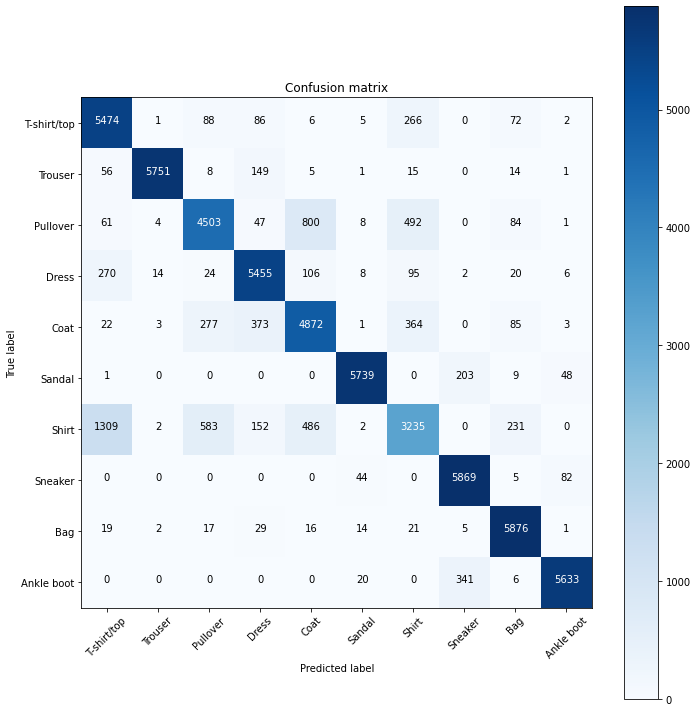

In [58]:
plt.figure(figsize=(10, 10))
plot_confusion_matrix(cm, train_set.classes)